# SST-NHF_feedback: coupling between SST anomalies and NHF anomalies in the eastern equatorial Pacific

Computes net surface heat flux anomalies (NHFA; sum of latent and sensible heat fluxes and longwave and shortwave radiations) regressed onto surface temperature anomalies (SSTA) both in the eastern equatorial Pacific (horizontal Niño3 average).

#### Reference observations:
TropFlux 1979-2018 (main)

NHF: OAFlux-ISCCP 1984-2009, DEEP-C 1985-2016, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023

SST: ERSSTv5 1854-2023, HadISST 1870-2023, COBE2 1850-2023, ERA5 1940-2022, 20CRv3 1836-2015, NCEP2 1979-2023


In [1]:
from esmvalcore.dataset import Dataset

from esmvalcore.config import CFG
CFG['rootpath']['OBS6'].append(r'/g/data/kj13/datasets/esmvaltool/obsdata-v2') #NCEP-DOE-R2 tos

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/esmvalcore/config/_config_object.py:639: ESMValCoreDeprecationWarning: Usage of the single configuration file ~/.esmvaltool/config-user.yml or specifying it via CLI argument `--config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please run `mkdir -p ~/.config/esmvaltool && mv /home/189/fc6164/.esmvaltool/config-user.yml ~/.config/esmvaltool` (or alternatively use a custom `--config_dir`) and omit `--config_file`.
  config_obj.reload()
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, rem

In [2]:
model_name = "ACCESS-ESM1-5"

model_ts_datasets = { 
model_name: 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20140101",
    dataset=model_name,
    grid="gn"
)}
model_ts_datasets[model_name].add_supplementary(short_name='areacella', mip='fx')


In [3]:
model_hfls_datasets = { 
model_name: 
    Dataset(
    short_name='hfls',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20140101",
    dataset=model_name,
    grid="gn"
)}

model_hfls_datasets[model_name].add_supplementary(short_name='areacella', mip='fx')

#rest variables
model_other = {}
for cvar in ['hfss','rlds','rlus','rsds','rsus']:
    
    model_other[cvar] = model_hfls_datasets[model_name].copy(short_name=cvar)


In [4]:
model_ts = {name: dataset.load() for name, dataset in model_ts_datasets.items()}

model_hfls = {name: dataset.load() for name, dataset in model_hfls_datasets.items()}
model_rest = {name: dataset.load() for name, dataset in model_other.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/esmvalcore/config/_config_valid

In [5]:
# load cubes, formula nhf
# nhf = -*hfls* -hfss + rlds - rlus + rsds - rsus #if 'd' make positive

model_nhf = - model_hfls[model_name] - model_rest['hfss'] + model_rest['rlds']- model_rest['rlus']+ model_rest['rsds']- model_rest['rsus']

In [6]:
obs_tos_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    timerange="19790101/20190101",
    tier=2),
# "ERA-Interim":
#     Dataset(
#     short_name='ts',
#     dataset='ERA-Interim',
#     mip="Amon",
#     project='OBS6',
#     type='reanaly',
#     tier=3)
}

obs_nhf_datasets = {
 "TROPFLUX": 
     Dataset(
     short_name='hfds',
     dataset='TROPFLUX',
     mip="Omon",
     project='OBS6',
     type='reanaly',
     timerange="19790101/20190101",
     tier=2)
}

In [7]:
obs_tos = {name: dataset.load() for name, dataset in obs_tos_datasets.items()}
obs_nhf = {name: dataset.load() for name, dataset in obs_nhf_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/esmvalcore/config/_config_validators.py:405: ESMValCoreDeprecationWarning: The configuration option or command line argument `config_file` has been deprecated in ESMValCore version 2.12.0 and is scheduled for removal in version 2.14.0. Please use the option `config_dir` instead.
  _handle_deprecation(option, deprecated_version, remove_version, more_info)


In [8]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import seasonal_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_season
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
from esmvalcore.preprocessor import extract_time
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import iris.plot as iplt
import numpy as np

In [9]:
def east(cube):
    nino3_region = {"start_longitude": 210., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_region(cube, **nino3_region)    
    cube = anomalies(cube, period="monthly")
    # cube = convert_units(cube, units="degC")
    cube = detrend(cube, dimension="time", method="linear")
    cube = regrid(cube, target_grid="1x1", scheme="linear")

    cube = area_statistics(cube, operator='mean')

    return cube


In [10]:
model_ts_prep = {name: east(dataset) for name, dataset in model_ts.items()}
model_nhf_prep = {model_name: east(model_nhf)}

In [11]:
obs_tos_prep = {name: east(dataset) for name, dataset in obs_tos.items()}
obs_nhf_prep = {name: east(dataset) for name, dataset in obs_nhf.items()}

## Calculate Linear regression

In [12]:

def linreg_1d(nhf_cube, ts_cube):
    B_data = ts_cube.data
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, nhf_cube.data, rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept

# linreg_1d(obs_nhf_prep["TROPFLUX"], obs_tos_prep["HadISST"])

In [13]:
mod_slope, mod_intcpt = linreg_1d(model_nhf_prep[model_name], model_ts_prep[model_name])
print('model ', mod_slope, mod_intcpt)

slope, intcpt = linreg_1d(obs_nhf_prep["TROPFLUX"], obs_tos_prep["HadISST"])

model  -5.1644278 4.2530136e-08


# Diagnostic Level 1

model points  (1968,) (1968,)
W m-2 K
obs points  (480,) (480,)
67.47739315032959


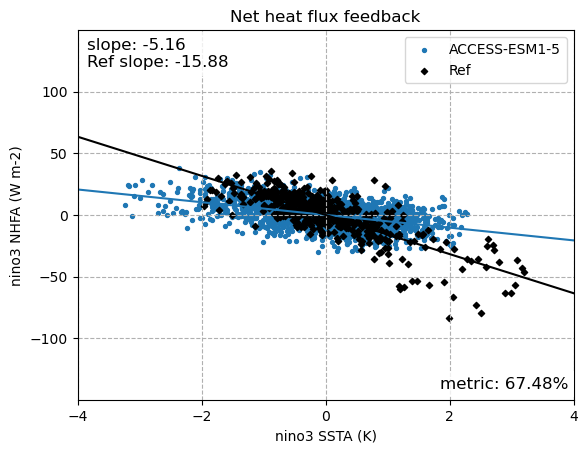

In [14]:
xseq = np.linspace(-4, 4, num=10)

plt.plot(xseq, mod_intcpt+mod_slope*xseq)

plt.plot(xseq, intcpt+slope*xseq, color='black')

metric_val = abs((mod_slope-slope)/slope)*100

print('model points ', model_nhf_prep[model_name].shape, model_ts_prep[model_name].shape) #scatter plot
print(model_nhf_prep[model_name].units, model_ts_prep[model_name].units)

plt.scatter(model_ts_prep[model_name].data, model_nhf_prep[model_name].data,label=model_name, s=8)
yunit = model_nhf_prep[model_name].units 
xunit = model_ts_prep[model_name].units

print('obs points ', obs_tos_prep["HadISST"].shape, obs_nhf_prep["TROPFLUX"].shape)
plt.scatter(obs_tos_prep["HadISST"].data, obs_nhf_prep["TROPFLUX"].data, label='Ref', s=10, c='black', marker='D')
plt.xlim(-4,4)
plt.xticks(np.arange(-4,5,2))
plt.ylim(-150,150)
plt.yticks(np.arange(-100,120,50))
plt.grid(linestyle='--')
plt.ylabel(f'nino3 NHFA ({yunit})')
plt.xlabel(f'nino3 SSTA ({xunit})') #°C
plt.legend()
plt.title('Net heat flux feedback')
## text slope
plt.text(0.02, 0.9, f'slope: {mod_slope:.2f} \nRef slope: {slope:.2f}', fontsize=12, ha='left',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(0.99, 0.03, f'metric: {metric_val:.2f}%', fontsize=12, ha='right',
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

print(metric_val)

**Figure 1**: scatterplot of sea surface temperature anomalies (SSTA) and net surface heat flux anomalies (NHFA) in the eastern equatorial Pacific (Niño3 averaged), showing the strength of the SST-to-NHF coupling (usually too weak by half; here slightly too strong). The black and blue markers show respectively the reference and the model. The metric is based on the slope of the regression and is the absolute value of the relative difference: abs((model-ref)/ref)*100.

# Diagnostic Level 2

In [15]:
import pandas as pd

def linreg_df(ts, nhf):
    B_data = np.array(ts)
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, np.array(nhf), rcond=None)
    slope, intercept = coefs[0], coefs[1]
    return slope, intercept

# df = pd.DataFrame({'tos':model_ts_prep[model_name].data, 'nhf':model_nhf_prep[model_name].data})
# linreg_df(df.loc[df['tos']<0, 'nhf'], df.loc[df['tos']<0, 'tos'])
# df.loc[df['tos']<0]

def plt_settings(slopes):
    plt.xlim(-4,4)
    plt.xticks(np.arange(-4,5,2))
    plt.ylim(-100,100)
    plt.yticks(np.arange(-100,120,50))
    plt.grid(linestyle='--')
    plt.ylabel(f'nino3 NHFA (W/m2)')
    plt.xlabel(f'nino3 SSTA (°C)') #
    print(slopes)
    plt.text(0.02, 0.85, f'slope(all): {slopes[0]:.2f}\nslope(x<0): {slopes[1]:.2f}\nslope(x>0): {slopes[2]:.2f}', fontsize=12, ha='left',
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    

In [16]:

def plt_lvl2_subplot(ts_cube, nhf_cube, dataset_label):
    
    df = pd.DataFrame({'tos':ts_cube.data, 'nhf':nhf_cube.data})
    slopes = []
    print(dataset_label, 'shape: ', df.shape)
    plt.scatter(ts_cube.data, nhf_cube.data, c='k', s=10)
    xseq = np.linspace(-50, 50, num=50)
    slope, intcpt = linreg_df(df['tos'], df['nhf'])
    plt.plot(xseq, intcpt+slope*xseq, c='black')
    slopes.append(slope)
    
    xseq = np.linspace(-50, 0, num=50) #
    slope, intcpt = linreg_df(df.loc[df['tos']<0, 'tos'], df.loc[df['tos']<0, 'nhf'])
    
    plt.plot(xseq, intcpt+slope*xseq, linewidth=3)
    slopes.append(slope)
    
    xseq = np.linspace(0, 50, num=50)
    slope, intcpt = linreg_df(df.loc[df['tos']>0, 'tos'], df.loc[df['tos']>0, 'nhf'])
    plt.plot(xseq, intcpt+slope*xseq, color='red', linewidth=3)
    slopes.append(slope)

    plt.title(dataset_label)
    plt_settings(slopes)

# print(plt.gcf().get_size_inches() * 2) #* plt.gcf().dpi

ACCESS-ESM1-5 shape:  (1968, 2)
[-5.1644278, -6.2170844, -3.5787907]
HadISST_TROPFLUX shape:  (480, 2)
[-15.879502, -11.467117, -18.829441]


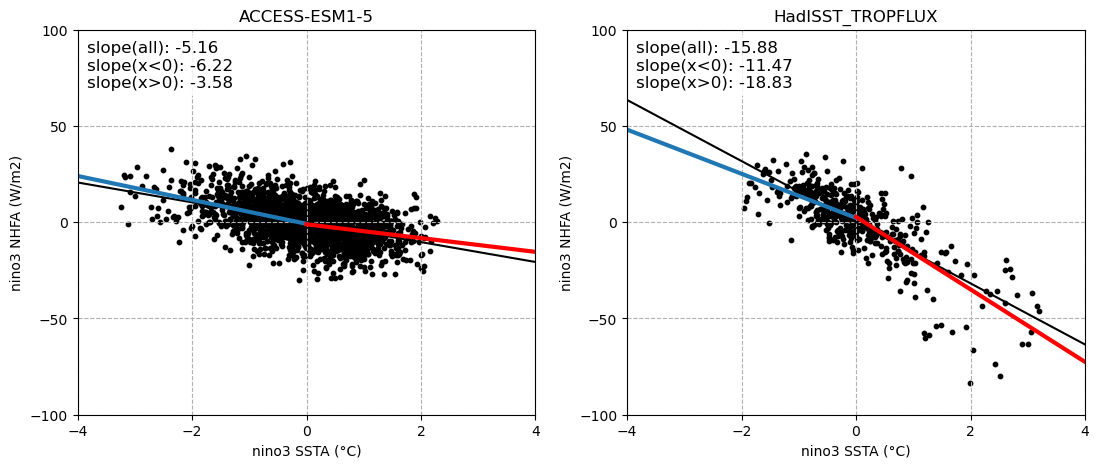

In [17]:
## plot figures
fig = plt.figure(figsize=(13, 5))
ax = plt.subplot(121)

plt_lvl2_subplot(model_ts_prep[model_name], model_nhf_prep[model_name], model_name)

ax = plt.subplot(122)
plt_lvl2_subplot(obs_tos_prep["HadISST"], obs_nhf_prep["TROPFLUX"], 'HadISST_TROPFLUX')

Figure 2: scatterplot of sea surface temperature anomalies (SSTA) and net surface heat flux anomalies (NHFA) in the eastern equatorial Pacific (Niño3 averaged), showing the possible nonlinearity in the strength of the SST-to-NHF coupling (usually shows a gentler slope for SSTA<0 and steeper slope for SSTA>0 in both reference and model). The black, red and blue lines and numbers show respectively linear regression computed for all SSTA, SSTA>0 and SSTA<0, the left and right scatterplots show respectively the reference and the model.

### Dive down Level 3:
The third level shows the local coupling in the equatorial Pacific.

In [18]:
#level 3 zonal runningaverage
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import mask_above_threshold, mask_below_threshold

def sst_eqp_area(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = mask_landsea(cube, mask_out="land")
    cube = convert_units(cube, units="degC")
    cube = extract_region(cube, **region)
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = regrid(cube, target_grid="1x1", scheme="linear") #issue on model, regrid needed on obs
    cube = area_statistics(cube, operator='mean') 
    return cube

def nhf_meri_eqp(cube):
    region = {"start_longitude": 150., "end_longitude": 270., "start_latitude": -5., "end_latitude": 5.}
    cube = mask_landsea(cube, mask_out="land") 
    cube = anomalies(cube, period="monthly")
    cube = detrend(cube, dimension="time", method="linear")
    cube = regrid(cube, target_grid="1x1", scheme="linear")   
    cube = extract_region(cube, **region)
    cube = meridional_statistics(cube,operator='mean')
    cube = rolling_window_statistics(cube, coordinate='longitude',operator='mean',window_length=30)
    return cube 

In [19]:
model_ts_prep = {name: sst_eqp_area(dataset) for name, dataset in model_ts.items()}
model_nhf_prep = {model_name: nhf_meri_eqp(model_nhf)}

obs_ts_prep = {name: sst_eqp_area(dataset) for name, dataset in obs_tos.items()}
obs_nhf_prep = {name: nhf_meri_eqp(dataset) for name, dataset in obs_nhf.items()}

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/cube.py:4330: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/cube.py:4881: IrisIgnoringBoundsWarning: The bounds of coordinate 'longitude' were ignored in the rolling window operation.
  warnings.warn(


In [20]:
def lin_regress_matrix(cubeA, cubeBsst):
    
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    if cubeA.shape[0] == cubeBsst.shape[0]:
        B_data = cubeBsst.data.flatten() # or all
    else:
        B_data = cubeBsst.data.compressed() # masked threshold cube (time,) 

    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    
    print('least squares data shapes ',B_with_intercept.shape, A_data.shape)
    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)

    # Create a new Iris Cube for the regression results
    result_cube = iris.cube.Cube(coefs[0], long_name='regression SSTA,SSHA',
                                 dim_coords_and_dims=[(cubeA.coord('longitude'), 0)])

    return result_cube


def feedback_nonlin(sst_cube, tauu_cube):
    tauu_aux = tauu_cube.copy()
    sst_coord = iris.coords.AuxCoord(sst_cube.data, sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)
    tauu_aux.add_aux_coord(sst_coord, 0)
    print(sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)

    below0 = iris.Constraint(surface_temperature=lambda cell: cell < 0) #change variable
    above0 = iris.Constraint(surface_temperature=lambda cell: cell > 0)
    ssta_neg = mask_above_threshold(sst_cube.copy(), 0) #x<0
    ssta_pos = mask_below_threshold(sst_cube.copy(), 0) #x>0
    xbelow0 = tauu_aux.extract(below0)
    xabove0 = tauu_aux.extract(above0)
    
    outreg_cube = lin_regress_matrix(xbelow0, ssta_neg)
    posreg_cube = lin_regress_matrix(xabove0, ssta_pos)

    return outreg_cube, posreg_cube

def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'
        

surface_temperature Surface Temperature ts degC
least squares data shapes  (908, 2) (908, 91)
least squares data shapes  (1060, 2) (1060, 91)
surface_temperature Surface Temperature ts K
least squares data shapes  (276, 2) (276, 91)
least squares data shapes  (204, 2) (204, 91)
least squares data shapes  (1968, 2) (1968, 91)
least squares data shapes  (480, 2) (480, 91)


Text(0.5, 1.0, 'Net heat flux feedback')

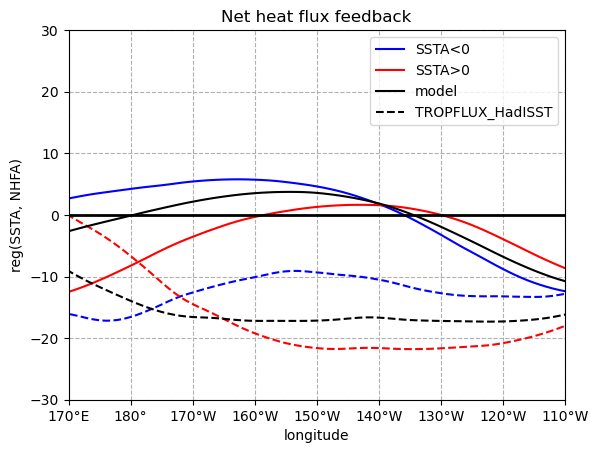

In [21]:
neg, pos = feedback_nonlin(model_ts_prep["ACCESS-ESM1-5"], model_nhf_prep["ACCESS-ESM1-5"])

qplt.plot(neg, color='blue', linestyle='solid', label='SSTA<0')

qplt.plot(pos, color='red', linestyle='solid', label='SSTA>0')

neg, pos = feedback_nonlin(obs_tos_prep["HadISST"], obs_nhf_prep["TROPFLUX"])
qplt.plot(neg, color='blue', linestyle='--')
qplt.plot(pos, color='red', linestyle='--')

cb = lin_regress_matrix(model_nhf_prep["ACCESS-ESM1-5"], model_ts_prep["ACCESS-ESM1-5"])
        
qplt.plot(cb, color='black', linestyle='solid', label='model')

cb2 = lin_regress_matrix(obs_nhf_prep["TROPFLUX"], obs_tos_prep["HadISST"])
qplt.plot(cb2, color='black', linestyle='--', label='TROPFLUX_HadISST')

plt.xlim(170, 250)
plt.xlabel('longitude')
plt.ylabel('reg(SSTA, NHFA)')
plt.grid(linestyle='--')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude))
plt.legend()
plt.ylim(-30,30)
plt.axhline(y=0, color='black', linewidth=2)
plt.title("Net heat flux feedback")

**Figure 3**: spatial structure of net surface heat flux anomalies (NHFA) regressed onto sea surface temperature anomalies (SSTA) both in the equatorial Pacific (meridional 5°S-5°N average; zonal 30° running average), showing the possible nonlinearity in the strength of the SST-to-NHF coupling (the reference shows the maximum coupling around the dateline, west of the dateline for SSTA<0, east of the dateline for SSTA>0, but the amplitude of the maximum coupling is about the same; usually the models simulate a weaker coupling, the maximum coupling is shifted westward and the models reproduce the displacement of the maximum coupling for all SSTA, SSTA<0, SSTA>0; here the model also simulates a too strong coupling in the far east). The black, red and blue lines and numbers show respectively linear regression computed for all SSTA, SSTA>0 and SSTA<0, the dashed and solid curves show respectively the reference and the model.

## Dive down level 4:

In [22]:
from esmvalcore.preprocessor import climate_statistics, extract_month

def feedback_nonlin_lvl4(sst_cube, tauu_cube): #nhf, sst
    tauu_aux = tauu_cube.copy()
    sst_coord = iris.coords.AuxCoord(sst_cube.data, sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)
    tauu_aux.add_aux_coord(sst_coord, 0)
    # print(sst_cube.standard_name, sst_cube.long_name, sst_cube.var_name, sst_cube.units)

    below0 = iris.Constraint(surface_temperature=lambda cell: cell < 0)
    above0 = iris.Constraint(surface_temperature=lambda cell: cell > 0)
    ssta_neg = mask_above_threshold(sst_cube.copy(), 0) #x<0
    ssta_pos = mask_below_threshold(sst_cube.copy(), 0) #x>0
    xbelow0 = tauu_aux.extract(below0)
    xabove0 = tauu_aux.extract(above0)
    
    outreg_cube = annual_structure_reg(xbelow0, ssta_neg)
    posreg_cube = annual_structure_reg(xabove0, ssta_pos)
    all_cube = annual_structure_reg(tauu_cube, sst_cube)

    return all_cube, outreg_cube, posreg_cube

def lin_regress_4(cubeA, cubeBsst):
    A_data = cubeA.data.reshape(cubeA.shape[0], -1)  # Shape (time, spatial_points)
    if cubeA.shape[0] == cubeBsst.shape[0]:
        B_data = cubeBsst.data.flatten() # or all
    else:
        B_data = cubeBsst.data.compressed() # compress masked
    # Add intercept term by stacking a column of ones with cubeB
    B_with_intercept = np.vstack([B_data, np.ones_like(B_data)]).T
    # print('least squares data shapes ',B_with_intercept.shape, A_data.shape)
    # Solve the linear equations using least squares method
    coefs, _, _, _ = np.linalg.lstsq(B_with_intercept, A_data, rcond=None)
    return coefs[0]
    
def annual_structure_reg(nhf_cube, ts_cube):
    months_reg = []
    for i in range(1,13):
        #extract for both cubes
        nhf = extract_month(nhf_cube, month=i)
        ts = extract_month(ts_cube, month=i)
        coefs = lin_regress_4(nhf, ts)
        # collect array for months
        months_reg.append(coefs)
    # print(len(coefs), type(coefs), coefs.shape)
    # get month_number coordinate from an existing cube
    m_cube = climate_statistics(ts_cube, operator='max', period='month')
    
    #create cube, x = months, y = lon
    result_cube = iris.cube.Cube(np.array(months_reg), long_name='regression',
                                 dim_coords_and_dims=[(nhf.coord('longitude'), 1), (m_cube.coord('month_number'), 0)])
    return result_cube  



(1968,) (1968, 91)


surface_temperature Surface Temperature ts degC
surface_temperature Surface Temperature ts K


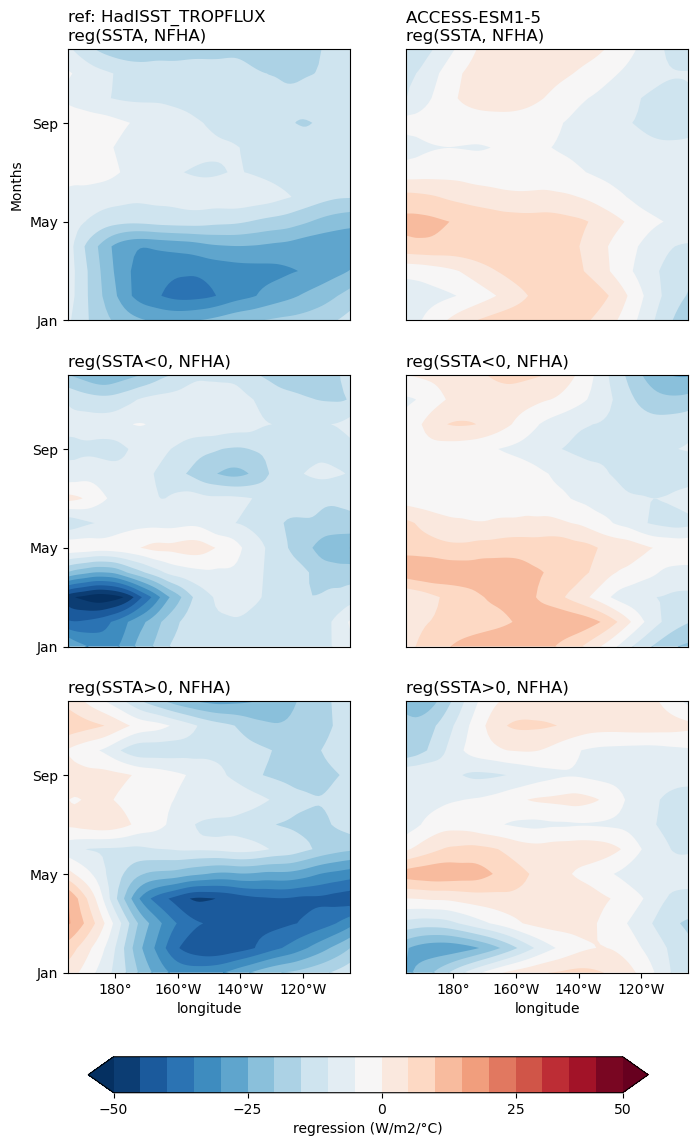

In [30]:
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

modells = feedback_nonlin_lvl4(model_ts_prep["ACCESS-ESM1-5"], model_nhf_prep["ACCESS-ESM1-5"])
obsls = feedback_nonlin_lvl4(obs_tos_prep["HadISST"], obs_nhf_prep["TROPFLUX"])
sub = ['', '<0', '>0']

fig = plt.figure(figsize=(8, 12))
i = 321
ax1 = plt.subplot(i)

for isub, cbls in enumerate(zip(obsls, modells)):
    # build ls 

    for cb in cbls:
        if i == 321:
            ax1.set_yticks(range(1, 13, 4))
            ax1.set_yticklabels(['Jan', 'May', 'Sep'] )
            ax1.set_ylabel('Months')
            ax1.set_title('ref: HadISST_TROPFLUX \nreg(SSTA, NFHA)', loc='left')
        else:
            ax2 = plt.subplot(i, sharex=ax1, sharey=ax1)
            ax2.set_title(f'reg(SSTA{sub[isub]}, NFHA)', loc='left')
            if i == 322:
                ax2.set_title('ACCESS-ESM1-5 \nreg(SSTA, NFHA)', loc='left')


        ## contour plt data
        cf1 = iplt.contourf(cb, coords=['longitude','month_number'], levels=np.arange(-50, 50, 5), extend='both', cmap="RdBu_r")
        
        if i < 325:
            plt.tick_params('x', bottom=False, labelbottom=False)
        else:
            plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_longitude)) #apply to bottom left =>325
            ax2.set_xlabel("longitude")
        
        if i%2 == 0:
            plt.tick_params(left=False, labelleft=False)
        
        i += 1


cax = plt.axes([0.15,0.01,0.7,0.03])
cbar = fig.colorbar(cf1, cax=cax, orientation='horizontal', extend='both', ticks=np.arange(-50, 51, 25))
cbar.set_label('regression (W/m2/°C)')

Figure 4: spatio-mean annual structure of net surface heat flux anomalies (NHFA) regressed onto sea surface temperature anomalies (SSTA) both in the equatorial Pacific (meridional 5°S-5°N average; zonal 30° running average), showing the possible nonlinearity in the strength of the SST-to-NHF coupling. The reference shows a strong seasonality with a strong coupling during the first half of the year and a weak one during the second half, in addition, the coupling is strong during the first half of the year when SSTA>0 and quite weak when SSTA<0 (but in the far west), indicating that this SSTA damping by heat fluxes is mainly active to terminate El Niño events. Usually models reproduces these aspects but the coupling is weaker and the coupling's seasonality is also weaker. The first, second and third rows show respectively linear regression computed for all SSTA, SSTA>0 and SSTA<0, the left and right Hovmöllers show respectively the reference and the model.